In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<h2 style="text-align:center;">Warren Buffett and the Interpretation of Financial Statements: The Search for the Company with a Durable Competitive Advantage.</h2>

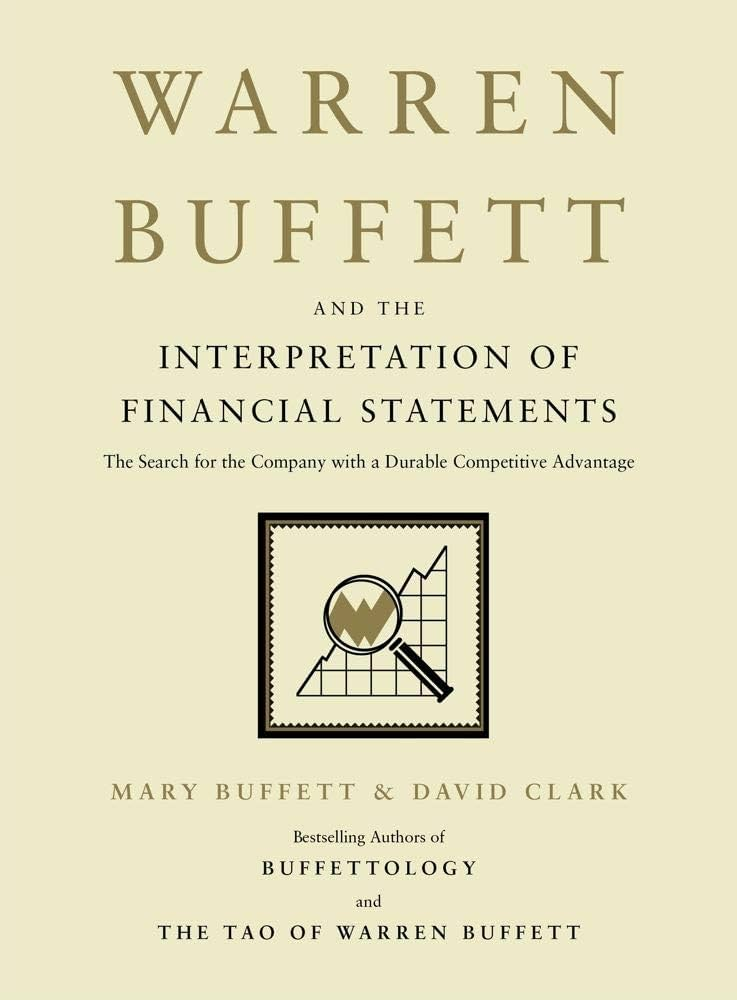

### This notebook is based on the various metrics discussed within the aforementioned book. Warren likes to find businesses with a strong competitive advantage which gives them the edge over a peer company. Warren uses these metrics as a jumping off point in the search for great companies that will make him rich. There is far more to this book than these quantifiable metrics and far more to making a judgement on a company than these metrics and thus should not be used to prejudice a company.

#### Disclaimer: Currently this code works with US-based companies and UK-based companies as far as I have tested. The source data is imperfect, inconsistent and prone to error.

In [57]:
import pandas as pd
import requests
import bs4
import math

stock = 'KO'
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"} 
url = 'https://stockanalysis.com/stocks/{}/financials/'.format(stock)
request = requests.get(url,headers=headers)
soup = bs4.BeautifulSoup(request.content,'lxml')
try:
    company_name = [i.text for i in soup.find('h1')][0]
except:
    url = 'https://stockanalysis.com/quote/lon/{}/financials/'.format(stock)
    request = requests.get(url,headers=headers)
    soup = bs4.BeautifulSoup(request.content,'lxml')
    company_name = [i.text for i in soup.find('h1')][0]
print(company_name)

income_url = requests.get(url)
income = pd.read_html(income_url.text)[0].reset_index().drop(columns=['index']).rename(columns={'Year':'index'})
bal_sheet_url = requests.get(url+'balance-sheet/')
bal_sheet = pd.read_html(bal_sheet_url.text)[0].reset_index().drop(columns=['index']).rename(columns={'Year':'index'})
cashflow_url = requests.get(url+'cash-flow-statement/')
cashflow = pd.read_html(cashflow_url.text)[0].reset_index().drop(columns=['index']).rename(columns={'Year':'index'})

dates = []
data = []
index = ['gross_profit_margin (> 0.4)','net_profit_margin (> 0.2)','SGA_burden (< 0.3)','interest_burden (< 0.15)','capex_burden (< 0.25)',
          'EPS','return_on_assets','return_on_equity','current_ratio','debt_to_equity_ratio','long_term_debt_divided_by_net_income (< 4)']
gross_profit_margins = []
net_profit_margins = []
SGA_burdens = []
interest_burdens = []
capex_burdens = []
EPSs = []
return_on_assetss = []
return_on_equitys = []
current_ratios = []
debt_to_equity_ratios = []
long_term_debt_divided_by_net_incomes = []
years = len(income.columns)

for date in range(1,years-1): 
    # Select latest data.
    selected_income_statement = income[['index',income.columns[date]]]
    selected_balance_sheet = bal_sheet[['index',bal_sheet.columns[date]]]
    selected_cashflow = cashflow[['index',cashflow.columns[date]]]

    # Select current year of observation.
    dates.append(str(selected_income_statement.columns[1]).split(' ')[0])

    ### Gross profit margin
    # Gross profit margin = Gross profit / Revenue.
    # The higher the better.
    # >40% companies with a competitive advantage.
    # <20% highly competitive market.
    gross_profit_margin = float(selected_income_statement[selected_income_statement['index'] == 'Gross Profit'].values[0][1]) / float(selected_income_statement[selected_income_statement['index'] == 'Revenue'].values[0][1])

    ### Net earnings / Revenue - Of the money the company generates, how much do they keep as profit?
    # Buffett believes that a high percentage of net earnings to revenue shows a company with a competitive advantage.
    # >20% shows a company with a competitive advantage.
    # <10% shows a fiercely competitive advantage.
    net_profit_margin = float(selected_income_statement[selected_income_statement['index'] == 'Net Income'].values[0][1]) / float(selected_income_statement[selected_income_statement['index'] == 'Revenue'].values[0][1])

    ### SGA / Gross profit - how much of the company’s overheads eat into profit.
    # SGA / Gross profit = SGA - Gross profit
    # The lower the better.
    # <30% is ‘fantastic’
    # >100% the company is in the red.
    try:
        SGA_burden = float(selected_income_statement[selected_income_statement['index'] == 'Selling, General & Admin'].values[0][1]) / float(selected_income_statement[selected_income_statement['index'] == 'Gross Profit'].values[0][1])
    except:
        SGA_burden = 0
        
    ### Interest / operating income - How much does a company spend paying interest on debt?
    # Interest / Operating income
    # <15% Warren considers very good. The company likely has little debt.
    try:
        interest_burden = float(selected_income_statement[selected_income_statement['index'] == 'Interest Expense / Income'].values[0][1]) / float(selected_income_statement[selected_income_statement['index'] == 'Operating Income'].values[0][1])
    except:
        interest_burden = 0
    
    ### Capex / net earnings - Does the company constantly need to reinvent itself or, retool, upgrade to stay ahead?
    # Time series analysis.
    # Capex to net earnings ratio = Capex / net earnings.
    # < 50% is a good place to look for a CA.
    # < 25% is a company that very likely has a CA.
    # Compare over a period of time such as a 10 year period for consistent low Capex.
    # Coca-Cola = 19%
    # Moody’s = 5%
    try:
        capex_burden = abs(float(selected_cashflow[selected_cashflow['index'] == 'Capital Expenditures'].values[0][1])) / float(selected_income_statement[selected_income_statement['index'] == 'Net Income'].values[0][1])
    except:
        capex_burden = 0
        
    ### Earnings per share - Time series analysis required.
    # EPS = Net income / number of shares outstanding.
    # Look for upward trend over a number of years.
    EPS = float(selected_income_statement[selected_income_statement['index'] == 'EPS (Basic)'].values[0][1])

    ### Return on Assets RoA - A measure of how efficient a company is.
    # The return on asset ratio = Net earnings / Total assets.
    # Coca-Cola has $43 billion in total assets and a RoA of 12%.
    # Moody’s has $1.7 billion in total assets and a RoA of 43%.
    return_on_assets = float(selected_income_statement[selected_income_statement['index'] == 'Net Income'].values[0][1]) / float(selected_balance_sheet[selected_balance_sheet['index'] == 'Total Assets'].values[0][1])

    ### Return on Equity - compared with companies in the same industry
    # Return on shareholders’ equity = Net earnings / Shareholder’s equity
    # Coca-Cola = 24%
    # American airlines = 4%
    # The higher the better.
    # Add the value of the treasury shares back to the shareholders equity and perform the RoE again. Compare the difference to see how much the treasury shares affect the RoE metric.
    return_on_equity = float(selected_income_statement[selected_income_statement['index'] == 'Net Income'].values[0][1]) / float(selected_balance_sheet[selected_balance_sheet['index'] == "Shareholders' Equity"].values[0][1])

    ### Current ratio - can the company pay its short term liabilities
    # Current ratio = Total Current Assets / Current Liabilities
    try:
        current_ratio = float(selected_balance_sheet[selected_balance_sheet['index'] == 'Total Current Assets'].values[0][1]) / float(selected_balance_sheet[selected_balance_sheet['index'] == 'Total Current Liabilities'].values[0][1])
    except:
        current_ratio = 0
        
    ### Debt-to-Equity (D/E) Ratio
    # Total liabilities to shareholders equity ratio = Total liabilities / Shareholder equity.
    # The lower the better.
    # Coca-Cola has a treasury share-adjusted ratio of 0.51, Moody’s 0.63.
    # Unless you are looking at a financial institution a ratio of below 0.8 is a good indicator of a CA.
    debt_to_equity_ratio = float(selected_balance_sheet[selected_balance_sheet['index'] == 'Total Liabilities'].values[0][1]) / float(selected_balance_sheet[selected_balance_sheet['index'] == "Shareholders' Equity"].values[0][1])

    ### Ability to pay long term debt in 4 years with net earnings
    # 4 x net income ≥ long term debt
    # If the long-term debt is less than 4 times the net earnings in one year, the company potentially has a CA.
    try:
        long_term_debt_divided_by_net_income = float(selected_balance_sheet[selected_balance_sheet['index'] == 'Long-Term Debt'].values[0][1]) / float(selected_income_statement[selected_income_statement['index'] == 'Net Income'].values[0][1])
    except:
        long_term_debt_divided_by_net_income = 0
        
    # Append current year's metrics.
    data.append([gross_profit_margin,net_profit_margin,SGA_burden,interest_burden,capex_burden,
            EPS,return_on_assets,return_on_equity,current_ratio,debt_to_equity_ratio,
            long_term_debt_divided_by_net_income])

df_dict = {}
data_index = 0
for date in dates:
    df_dict.update({date:data[data_index]})
    data_index += 1
df = pd.DataFrame(data=df_dict,index=index,columns=dates).reset_index().rename(columns={'index':company_name})

# Gross margin coloring.
def gross_profit_margin(val):
    color = 'green' if val >= 0.4 else 'red'
    return 'color: %s' % color
df = df.style.applymap(gross_profit_margin,
    subset=pd.IndexSlice[0,dates])

# Net margin coloring.
def net_profit_margin(val):
    color = 'green' if val >= 0.2 else 'red'
    return 'color: %s' % color
df.applymap(net_profit_margin,
    subset=pd.IndexSlice[1,dates])

# SGA burden coloring.
def SGA_burden(val):
    color = 'green' if val < 0.3 and val > 0 else 'red'
    return 'color: %s' % color
df.applymap(SGA_burden,
    subset=pd.IndexSlice[2,dates])

# Interest burden coloring.
try:
    def interest_burden(val):
        color = 'green' if val < 0.15 and val > 0 or math.isnan(val) else 'red'
        return 'color: %s' % color
    df.applymap(interest_burden,
        subset=pd.IndexSlice[3,dates])
except:
    pass

# Capex burden coloring.
try:
    def capex_burden(val):
        color = 'green' if val < 0.25 and val > 0 else 'red'
        return 'color: %s' % color
    df.applymap(capex_burden,
        subset=pd.IndexSlice[4,dates])
except:
    pass

# EPS coloring.
try:
    df.background_gradient(cmap='RdYlGn',axis=1,
        subset=pd.IndexSlice[5,dates])
except:
    pass

# RoA coloring.
try:
    df.background_gradient(cmap='RdYlGn',axis=1,
        subset=pd.IndexSlice[6,dates])
except:
    pass

# RoE coloring.
try:
    df.background_gradient(cmap='RdYlGn',axis=1,
        subset=pd.IndexSlice[7,dates])
except:
    pass

# Current ratio coloring.
try:
    def current_ratio(val):
        color = 'green' if val >= 1 else 'red'
        return 'color: %s' % color
    df.applymap(current_ratio,
        subset=pd.IndexSlice[8,dates])
except:
    pass

# Long-term debt to net income coloring.
try:
    def long_term_debt_divided_by_net_income(val):
        color = 'green' if val <= 4 and val > 0 else 'red'
        return 'color: %s' % color
    df = df.applymap(long_term_debt_divided_by_net_income,
        subset=pd.IndexSlice[10,dates])
except:
    pass

# Debt to equity coloring.
try:
    df.background_gradient(cmap='RdYlGn_r',axis=1,
        subset=pd.IndexSlice[9,dates])
except:
    pass

df

The Coca-Cola Company (KO)


,The Coca-Cola Company (KO),2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
0,gross_profit_margin (> 0.4),0.581434,0.602716,0.593112,0.607712,0.619038,0.621092,0.606693,0.605319,0.611092,0.606843
1,net_profit_margin (> 0.2),0.221886,0.252775,0.234658,0.239360,0.187580,0.034464,0.155913,0.165959,0.154311,0.183207
2,SGA_burden (< 0.3),0.515118,0.521246,0.496961,0.534420,0.518156,0.570628,0.605166,0.612673,0.612544,0.608800
3,interest_burden (< 0.15),0.080851,0.154928,0.159720,0.093793,0.103802,0.109994,0.084671,0.098075,0.049753,0.045268
4,capex_burden (< 0.25),0.147663,0.128851,0.127533,0.120628,0.202052,1.315705,0.323579,0.335737,0.307551,0.284133
5,EPS,2.200000,2.260000,1.800000,2.090000,1.510000,0.290000,1.510000,1.690000,1.620000,1.940000
6,return_on_assets,0.102864,0.103557,0.088744,0.103263,0.077317,0.014199,0.074791,0.081681,0.077133,0.095320
7,return_on_equity,0.395851,0.424845,0.401420,0.469944,0.378894,0.073102,0.283020,0.287665,0.234103,0.258765
8,current_ratio,1.145356,1.130075,1.317718,0.756720,0.866166,1.343863,1.281848,1.240113,1.018904,1.125598
9,debt_to_equity_ratio,2.776893,3.021610,3.420488,3.439387,3.778223,4.036961,2.777296,2.513579,2.027111,1.706659
